## Imports

In [80]:
import numpy as np
import pandas as pd 

from sklearn.preprocessing import LabelEncoder

import os

import warnings
warnings.filterwarnings('ignore')

import gc
import re

import matplotlib.pyplot as plt
import seaborn as sns

# EDA : Analyse exploratoire

nous pouvons lister tous les fichiers de données disponibles. Il y a un total de 9 fichiers :  

1 fichier principal pour l’entraînement (avec la cible),  

1 fichier principal pour le test (sans la cible),  

1 fichier d’exemple de soumission,  

et 6 autres fichiers contenant des informations supplémentaires sur chaque prêt.  

In [2]:
# List files available
print(os.listdir("../input/"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [3]:
# Training data
app_train = pd.read_csv('../input/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Les données d’entraînement contiennent 307 511 observations (chacune correspondant à un prêt distinct) et 122 variables (caractéristiques), y compris la variable TARGET (la cible que nous voulons prédire).

In [4]:
# Testing data features
app_test = pd.read_csv('../input/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Le jeu de test est nettement plus petit et ne contient pas de colonne TARGET.  
Il sera ecarté de notre analyse 

## Examiner la distribution de la colonne cible
La cible est ce que l’on nous demande de prédire :  

soit un 0 si le prêt a été remboursé à temps,  

soit un 1 indiquant que le client a rencontré des difficultés de paiement.  

Nous pouvons commencer par examiner le nombre de prêts qui entrent dans chaque catégorie.  

In [5]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

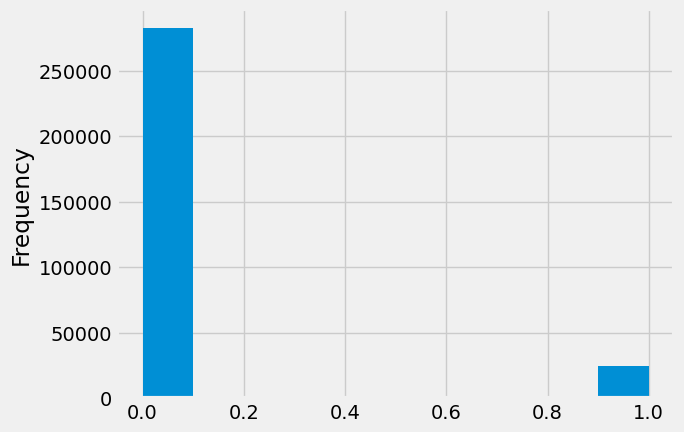

In [6]:
plt.style.use('fivethirtyeight')
app_train['TARGET'].astype(int).plot.hist();

À partir de ces informations, nous constatons qu’il s’agit d’un problème de classes déséquilibrées.  
Il y a en effet beaucoup plus de prêts qui ont été remboursés à temps que de prêts qui ne l’ont pas été.  

## Valeurs manquantes

In [7]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [8]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4


## Types des colonnes

In [9]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [10]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

The training and testing datasets now have the same features which is required for machine learning. The number of features has grown significantly due to one-hot encoding. At some point we probably will want to try [dimensionality reduction (removing features that are not relevant)](https://en.wikipedia.org/wiki/Dimensionality_reduction) to reduce the size of the datasets.

### Valeurs abberantes


In [11]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Pas de valeurs abberantes pour la feature DAYS_BIRTH

In [12]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

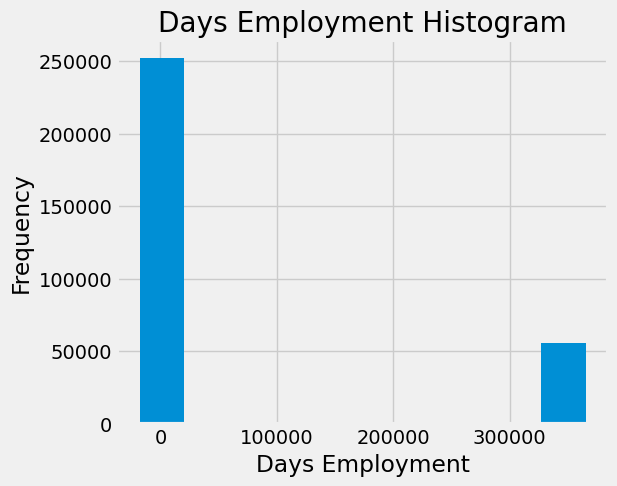

In [13]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.tight_layout()
plt.xlabel('Days Employment');

Dans DAYS_EMPLOYED, la valeur 365243 signifie « pas employé

In [14]:
app_train['CODE_GENDER'].value_counts()

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

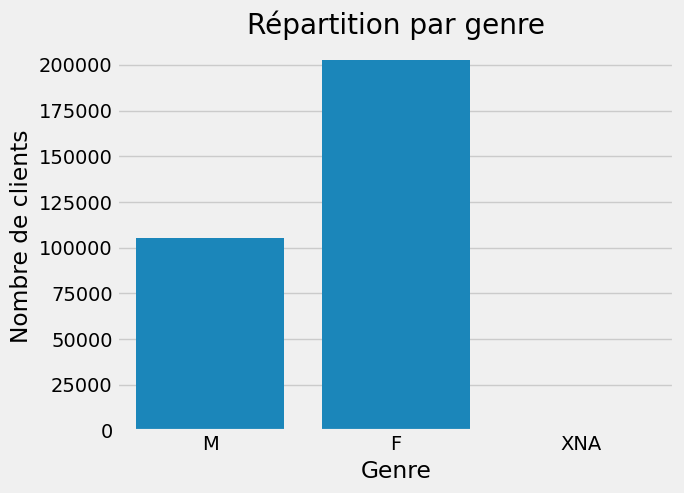

In [15]:
sns.countplot(data=app_train, x='CODE_GENDER')
plt.title('Répartition par genre')
plt.xlabel('Genre')
plt.ylabel('Nombre de clients')
plt.show()

Nous avons 4 valeurs abberantes XNA

### Correlations

Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the `.corr` dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some [general interpretations of the absolute value of the correlation coefficent](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf) are:


* .00-.19 “very weak”
*  .20-.39 “weak”
*  .40-.59 “moderate”
*  .60-.79 “strong”
* .80-1.0 “very strong”


In [16]:
# Find correlations with the target and sort
correlations = app_train.select_dtypes(include=['number']).corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


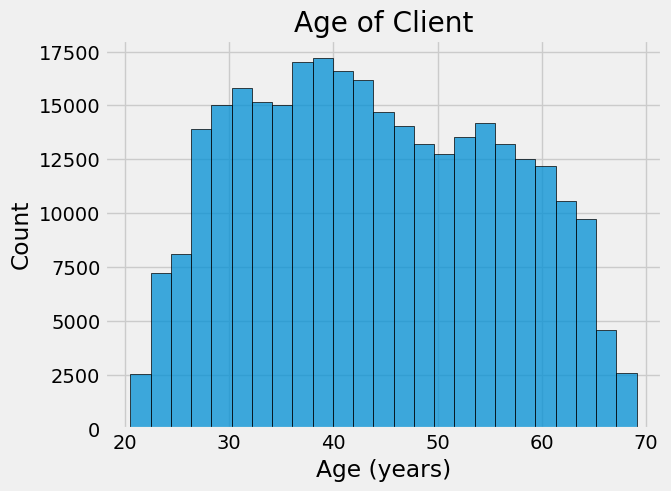

In [17]:
sns.histplot(app_train['DAYS_BIRTH'] / -365, bins=25, edgecolor='k')

plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.show()

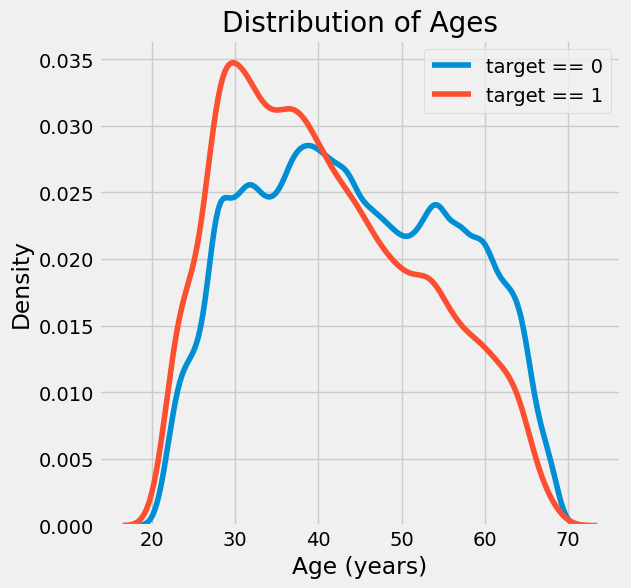

In [18]:
plt.figure(figsize = (6, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')
plt.legend()

moyenne des défauts de remboursement des prêts par tranche d’âge

In [19]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / -365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,-9461,25.920548,"(25.0, 30.0]"
1,0,-16765,45.931507,"(45.0, 50.0]"
2,0,-19046,52.180822,"(50.0, 55.0]"
3,0,-19005,52.068493,"(50.0, 55.0]"
4,0,-19932,54.608219,"(50.0, 55.0]"
5,0,-16941,46.413699,"(45.0, 50.0]"
6,0,-13778,37.747945,"(35.0, 40.0]"
7,0,-18850,51.643836,"(50.0, 55.0]"
8,0,-20099,55.065753,"(55.0, 60.0]"
9,0,-14469,39.641096,"(35.0, 40.0]"


In [20]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,-8532.795625,23.377522
"(25.0, 30.0]",0.111436,-10155.219250,27.822518
"(30.0, 35.0]",0.102814,-11854.848377,32.479037
"(35.0, 40.0]",0.089414,-13707.908253,37.555913
"(40.0, 45.0]",0.078491,-15497.661233,42.459346
"(45.0, 50.0]",0.074171,-17323.900441,47.462741
"(50.0, 55.0]",0.066968,-19196.494791,52.593136
"(55.0, 60.0]",0.055314,-20984.262742,57.491131
"(60.0, 65.0]",0.052737,-22780.547460,62.412459


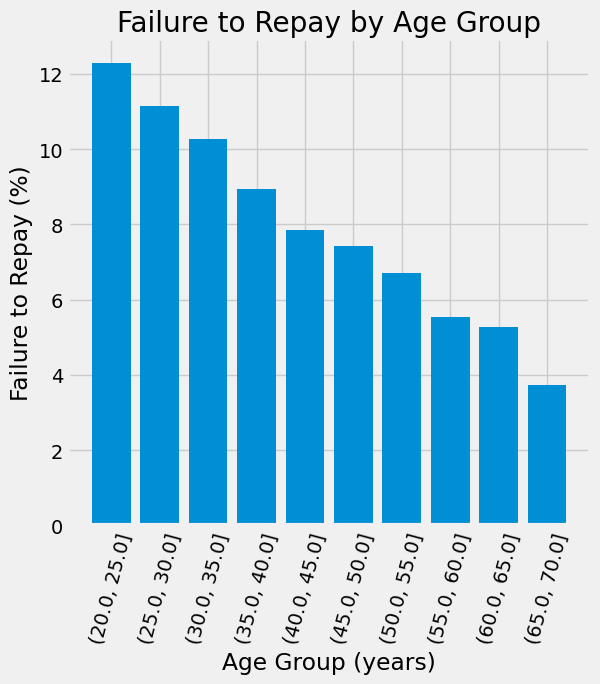

In [21]:
plt.figure(figsize = (6, 6))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

Tendance observée : les clients plus jeunes présentent un taux de non-remboursement nettement plus élevé (supérieur à 10 % pour les plus jeunes, contre moins de 5 % pour les plus âgés).

### Exterior Sources

Sources externes :
Les trois variables présentant les corrélations négatives les plus fortes avec la cible sont EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3.  

Signification :
D’après la documentation, ces variables correspondent à un « score normalisé provenant d’une source de données externe ». Representant une note de crédit agrégée, construite à partir de multiples sources.  

Analyse à venir :
Nous allons examiner plus en détail ces variables, en commençant par visualiser leurs corrélations avec la cible et entre elles.  

In [22]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,-0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,-0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,-0.205478
DAYS_BIRTH,0.078239,-0.600610,-0.091996,-0.205478,1.000000


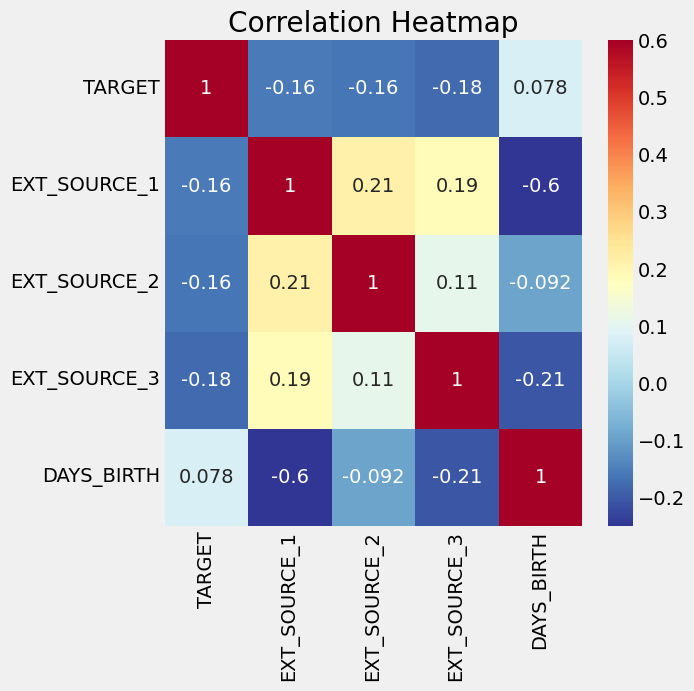

In [23]:
plt.figure(figsize = (6, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Les trois variables EXT_SOURCE présentent des corrélations négatives avec la cible, ce qui signifie que plus leur valeur est élevée, plus le client est susceptible de rembourser son prêt.  

On observe également que DAYS_BIRTH est positivement corrélé avec EXT_SOURCE_1, suggérant que l’âge du client pourrait être l’un des facteurs entrant dans ce score.  

Nous allons maintenant examiner la distribution de chacune de ces variables selon la valeur de la cible, afin de visualiser leur effet sur le risque de défaut.  

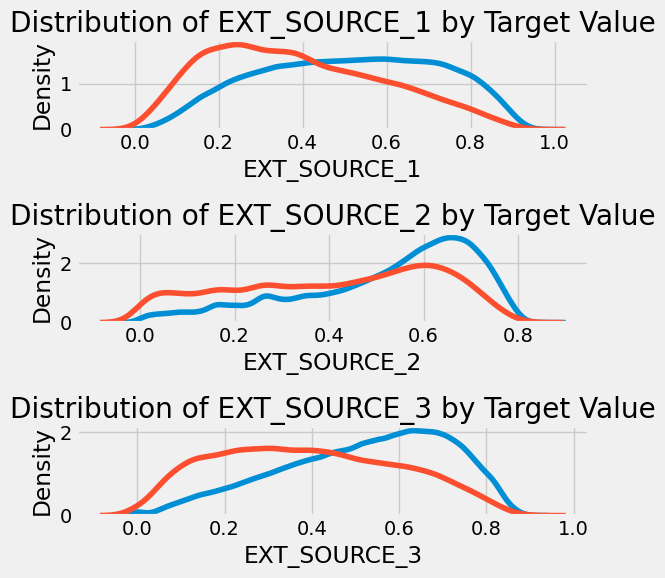

In [24]:
plt.figure(figsize = (6, 6))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout()
    

## Pairs Plot

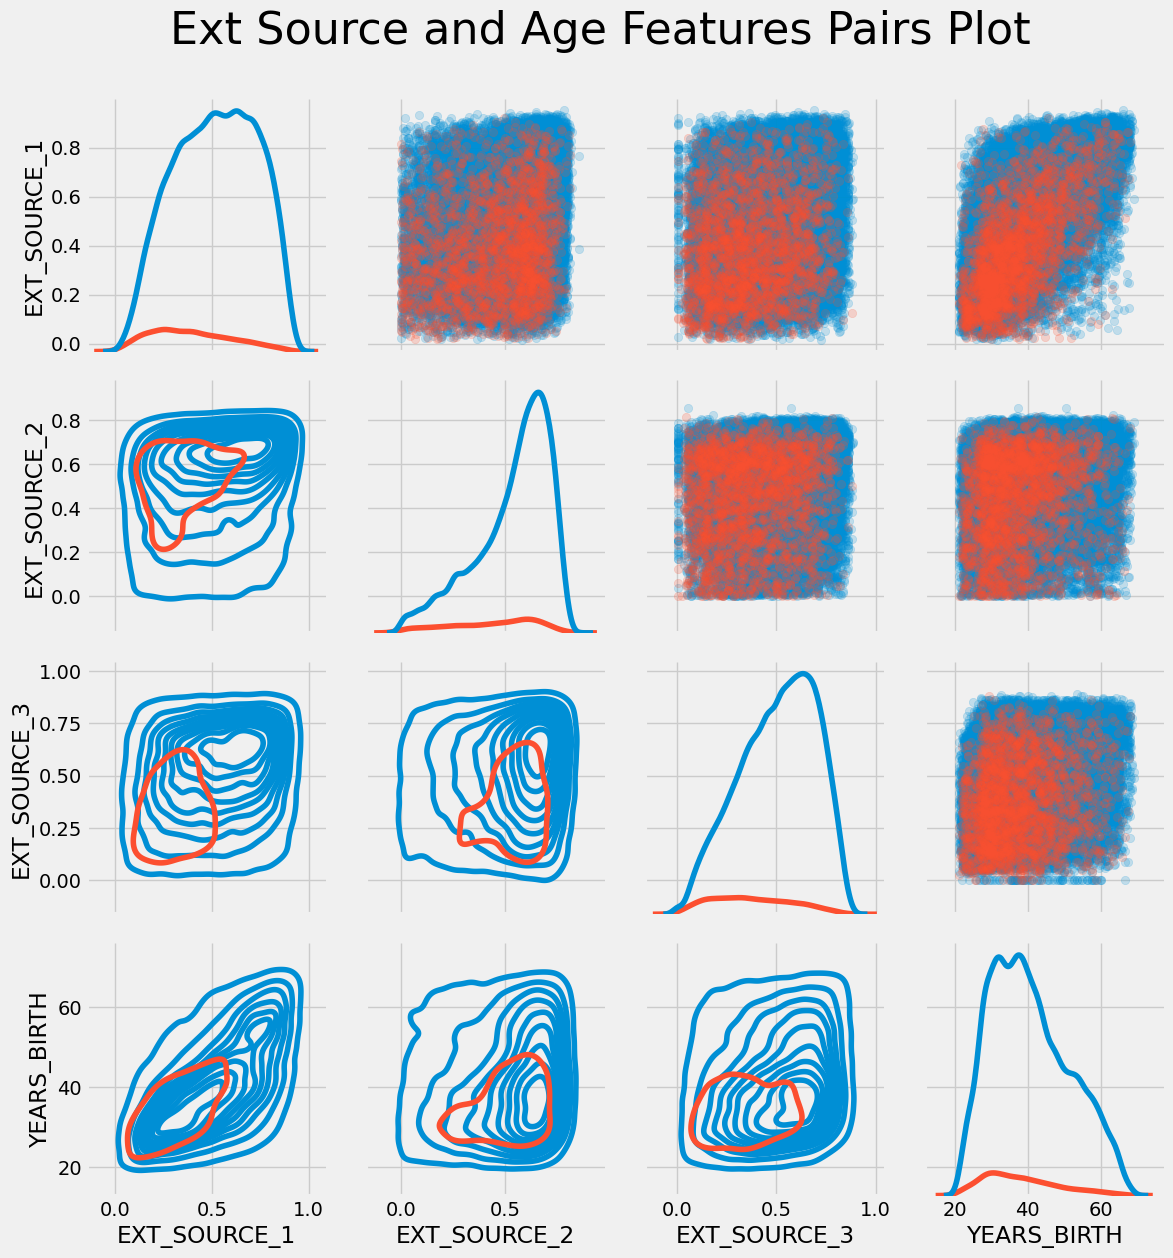

In [25]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, height = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

Sur ce graphique, le rouge indique les prêts non remboursés, tandis que le bleu représente les prêts remboursés.
On peut ainsi observer les différentes relations présentes dans les données.  

Il semble notamment y avoir une relation linéaire positive modérée entre EXT_SOURCE_1 et DAYS_BIRTH (ou YEARS_BIRTH), ce qui suggère que cette variable pourrait intégrer l’âge du client.  

# Nettoyage mémoire a réaliser

# Feature Engineering

 Ajout des données externes transformées et agrégées
- **Bureau + Bureau Balance :**
  - Agrégation des crédits passés et actuels par client (`min`, `max`, `mean`, etc.).
  - Création de features séparées pour les crédits actifs et les crédits fermés.

- **Previous Applications :**
  - Agrégation des anciennes demandes de crédit par client.
  - Création de features spécifiques pour les demandes approuvées et refusées.

- **POS CASH balance :**
  - Agrégation des crédits renouvelables (POS / Cash loans) par client.
  - Comptage du nombre total de comptes POS.

- **Installments Payments :**
  - Calcul des retards (DPD), des paiements anticipés (DBD) et des ratios payé/dû.
  - Agrégation par client pour obtenir des statistiques globales.

- **Credit Card Balance :**
  - Agrégation des historiques mensuels des cartes de crédit.
  - Calcul du nombre total de lignes carte de crédit par client.


In [26]:
from contextlib import contextmanager
import time

@contextmanager
def timer(title):
    t0 = time.time()          
    yield                     
    print("{} - done in {:.0f}s".format(title, time.time() - t0)) 

In [27]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [36]:
def application_train_test(num_rows = None, nan_as_category = False):
    # Lire uniquement les données d'entraînement
    df = pd.read_csv('../input/application_train.csv', nrows=num_rows)
    print("Train samples: {}".format(len(df)))
     
    # Supprimer les 4 valeurs aberrantes où CODE_GENDER == 'XNA'
    df = df[df['CODE_GENDER'] != 'XNA']

    # Encodage binaire pour certaines variables catégorielles à 2 modalités
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])

    # Encodage one-hot pour les autres variables catégorielles
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # Remplacer les valeurs 365243 de DAYS_EMPLOYED par NaN (valeur spéciale signifiant pas employé)
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

    # Créer de nouvelles features (ratios, pourcentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']


    return df

In [29]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('../input/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('../input/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [30]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('../input/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [31]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('../input/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [32]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('../input/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [33]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('../input/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [34]:
def build_features(debug=False):
    """
    Charge toutes les tables, crée les features, et fusionne
    en un seul DataFrame final prêt pour le modeling.
    """
    num_rows = 10000 if debug else None
    
    # Application train + test
    df = application_train_test(num_rows)
    
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
        
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
        
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
        
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
        
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
        
    return df


In [78]:
def clean_feature_names(df):
    df.columns = [
        re.sub(r'[^a-zA-Z0-9_]', '_', col)  # Remplace tout sauf lettres, chiffres et _
        .replace('__', '_')                  # Évite les doubles __
        .strip('_')                         # Supprime les _ en début/fin
        for col in df.columns
    ]
    return df

In [37]:
# Pré-processing et Feature Engineering
with timer("Build all features"):
    data_clean = build_features()

Train samples: 307511
Process bureau and bureau_balance - done in 14s
Process previous_applications - done in 14s
Process POS-CASH balance - done in 8s
Process installments payments - done in 18s
Process credit card balance - done in 13s
Build all features - done in 69s


In [81]:
# Nettoyage des noms de colonnes
data_clean = clean_feature_names(data_clean)

In [82]:
data_clean

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,False,0.0,0.0,0.0,False,False,0.0,0.0,0.0,6.0
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307509,456254,1,1,0,0,0,171000.0,370107.0,20205.0,319500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
# Missing values statistics
missing_values = missing_values_table(data_clean)
missing_values.head(10)

Your selected dataframe has 797 columns.
There are 616 columns that have missing values.


,Missing Values,% of Total Values
REFUSED_AMT_DOWN_PAYMENT_MAX,262339,85.3
REFUSED_AMT_DOWN_PAYMENT_MEAN,262339,85.3
REFUSED_RATE_DOWN_PAYMENT_MEAN,262339,85.3
REFUSED_RATE_DOWN_PAYMENT_MAX,262339,85.3
REFUSED_RATE_DOWN_PAYMENT_MIN,262339,85.3
REFUSED_AMT_DOWN_PAYMENT_MIN,262339,85.3
REFUSED_APP_CREDIT_PERC_VAR,258350,84.0
CC_AMT_PAYMENT_CURRENT_VAR,246888,80.3
CC_CNT_DRAWINGS_POS_CURRENT_VAR,246814,80.3
CC_CNT_DRAWINGS_ATM_CURRENT_VAR,246814,80.3


# Entraînement des modèles

In [101]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb

import mlflow
import mlflow.lightgbm

from mlflow.models.signature import infer_signature

from sklearn.metrics import roc_auc_score, accuracy_score

In [86]:
# Définir X et y
X = data_clean.drop(['TARGET'], axis=1)
y = data_clean['TARGET']

In [87]:
X.dtypes.value_counts()

float64    605
bool       133
int64       42
object      16
Name: count, dtype: int64

In [88]:
X = X.astype('float32')

In [89]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [90]:
print(f" X_train : {X_train.shape[0]} lignes, {X_train.shape[1]} features")
print(f" y_train : {y_train.shape[0]} lignes")
print(f" X_test  : {X_test.shape[0]} lignes, {X_test.shape[1]} features")
print(f" y_test  : {y_test.shape[0]} lignes")

 X_train : 246005 lignes, 796 features
 y_train : 246005 lignes
 X_test  : 61502 lignes, 796 features
 y_test  : 61502 lignes


In [91]:
X

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007.0,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251.0,0.0,0.0,1.0,0.0,157500.0,254700.0,27558.0,225000.0,0.032561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252.0,1.0,0.0,0.0,0.0,72000.0,269550.0,12001.5,225000.0,0.025164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253.0,1.0,0.0,0.0,0.0,153000.0,677664.0,29979.0,585000.0,0.005002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307509,456254.0,1.0,0.0,0.0,0.0,171000.0,370107.0,20205.0,319500.0,0.005313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
with mlflow.start_run():
    
    # Entraînement
    model = lgb.LGBMClassifier()
    model.fit(X_train, y_train)
    
    # Prédictions
    y_proba = model.predict_proba(X_test)[:, 1]  # pour ROC AUC
    y_pred = model.predict(X_test)

    y_proba_train = model.predict_proba(X_train)[:, 1]
    y_pred_train = model.predict(X_train)
    
    # Calcul des métriques
    auc = roc_auc_score(y_test, y_proba)
    accuracy = accuracy_score(y_test, y_pred)

    auc_train = roc_auc_score(y_train, y_proba_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    
    # Log des métriques
    mlflow.log_metric("roc_auc", auc)
    mlflow.log_metric("accuracy", accuracy)

    mlflow.log_metric("roc_auc_train", auc_train)
    mlflow.log_metric("accuracy_train", accuracy_train)
    
    # Log des hyperparamètres
    for param_name, value in model.get_params().items():
        mlflow.log_param(param_name, value)

    # Log du modèle
    signature = infer_signature(X_train, model.predict(X_train))
    mlflow.lightgbm.log_model(model, name="model", signature=signature, input_example=X_train.iloc[:5])

[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.917913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99889
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 786
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469
